In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

In [47]:
class NoisePSDGenerator:
    def __init__(self, fs=1000, duration=1.0):
        self.fs = fs            # Sampling frequency
        self.duration = duration  # Duration of the noise signal
        self._noise_type = None

    def generate_white_noise(self):
        self.noise_type = 'White'
        return np.random.normal(0, 1, int(self.fs * self.duration))

    def generate_pink_noise(self):
        self.noise_type = 'Pink'
        # Using Voss-McCartney algorithm to generate pink noise
        num_samples = int(self.fs * self.duration)
        b = [0.0] * 16
        pink_noise = np.zeros(num_samples)
        for i in range(num_samples):
            white = np.random.randn()
            b[0] = 0.99765 * b[0] + white * 0.0990460
            b[1] = 0.96300 * b[1] + white * 0.2965164
            b[2] = 0.57000 * b[2] + white * 1.0526913
            pink_noise[i] = white * 0.1848 + sum(b)
        return pink_noise

    def generate_brownian_noise(self):
        self.noise_type = 'Brownian'
        # Integrating white noise to generate brownian noise
        white_noise = np.random.normal(0, 1, int(self.fs * self.duration))
        return np.cumsum(white_noise)
    
    def generate_violet_noise(self):
        white_noise = self.generate_white_noise()
        return np.diff(white_noise) * self.fs  # Differentiating white noise

    def compute_psd(self, signal):
        return welch(signal, self.fs, nperseg=len(signal))

    def plot_psd(self, frequencies, psd, noise_type):
        plt.semilogy(frequencies, psd)
        plt.title(f'Power Spectral Density of {noise_type} Noise')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [V**2/Hz]')
        plt.grid(True)
        plt.show()
        
    def generate_time_series_from_psd(self, psd):
        N = len(psd) * 2 - 2
        random_phase = np.exp(1j * 2 * np.pi * np.random.rand(N // 2 + 1))

        # Reconstruct the complex spectrum
        complex_spectrum = np.sqrt(psd) * random_phase

        # Inverse Fourier Transform
        time_series = np.fft.irfft(complex_spectrum, n=N)

        # Time vector
        t = np.arange(N) / self.fs
        return t, time_series
        
    def plot_time_series_comparison(self, original, reconstructed, title):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(original)
        plt.title(f"Original {title} (Time Domain)")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")

        plt.subplot(1, 2, 2)
        plt.plot(reconstructed)
        plt.title(f"Reconstructed {title} (Time Domain)")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")

        plt.tight_layout()
        plt.show()

    def plot_psd_comparison(self, original, reconstructed, fs, title):
        plt.figure(figsize=(12, 4))

        # Original signal PSD
        f_orig, psd_orig = welch(original, fs, nperseg=len(original))

        plt.subplot(1, 2, 1)
        plt.semilogy(f_orig, psd_orig)
        plt.title(f"Original {title} (Frequency Domain)")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD [V**2/Hz]")

        # Reconstructed signal PSD
        f_recon, psd_recon = welch(reconstructed, fs, nperseg=len(original))

        plt.subplot(1, 2, 2)
        plt.semilogy(f_recon, psd_recon)
        plt.title(f"Reconstructed {title} (Frequency Domain)")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD [V**2/Hz]")

        plt.tight_layout()
        plt.show()

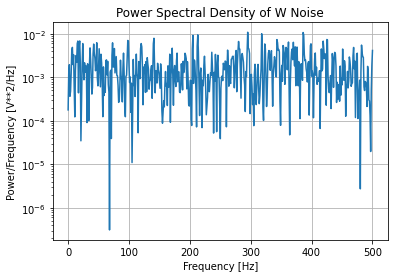

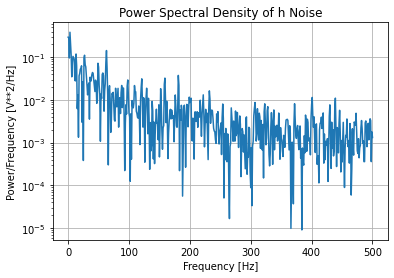

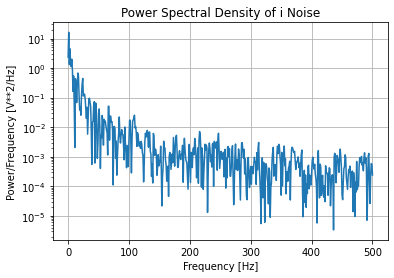

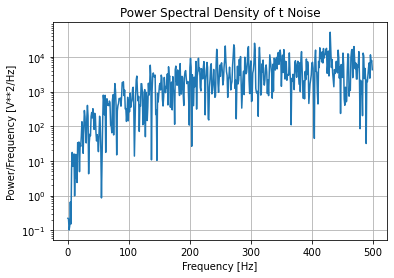

Wall time: 2.59 s


In [48]:
%%time
# Example usage
noise_psd_gen = NoisePSDGenerator(fs=1000, duration=1.0)
white_noise = noise_psd_gen.generate_white_noise()
pink_noise = noise_psd_gen.generate_pink_noise()
brownian_noise = noise_psd_gen.generate_brownian_noise()
violet_noise = noise_psd_gen.generate_violet_noise()

PSD_list = [white_noise, pink_noise, brownian_noise, violet_noise]
name_list = ['White', 'Pink', 'Brownian', 'Violet']

# Compute and plot PSD for each noise type
for noise, name in zip(PSD_list, noise_type):
    frequencies, psd = noise_psd_gen.compute_psd(noise)
    noise_psd_gen.plot_psd(frequencies, psd, name)

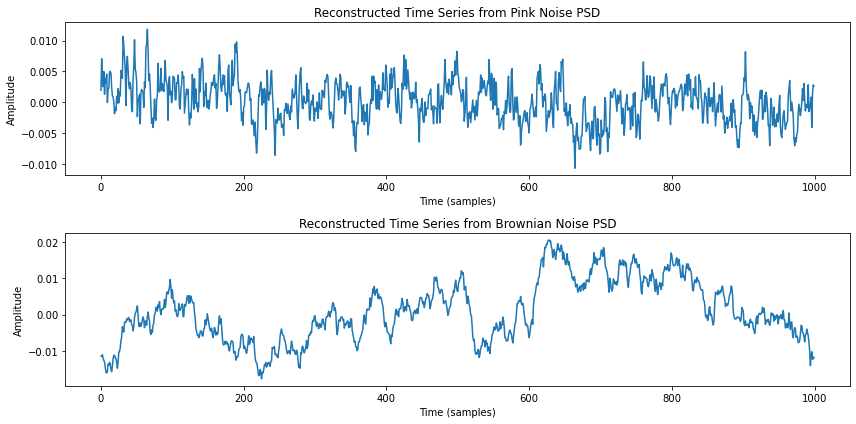

In [49]:
frequencies, pink_psd = noise_psd_gen.compute_psd(pink_noise)
_, brownian_psd = noise_psd_gen.compute_psd(brownian_noise)

# Generate time series from PSD
_, pink_reconstructed = noise_psd_gen.generate_time_series_from_psd(pink_psd)
_, brownian_reconstructed = noise_psd_gen.generate_time_series_from_psd(brownian_psd)

# Plot the reconstructed time series
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(pink_reconstructed)
plt.title("Reconstructed Time Series from Pink Noise PSD")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(brownian_reconstructed)
plt.title("Reconstructed Time Series from Brownian Noise PSD")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

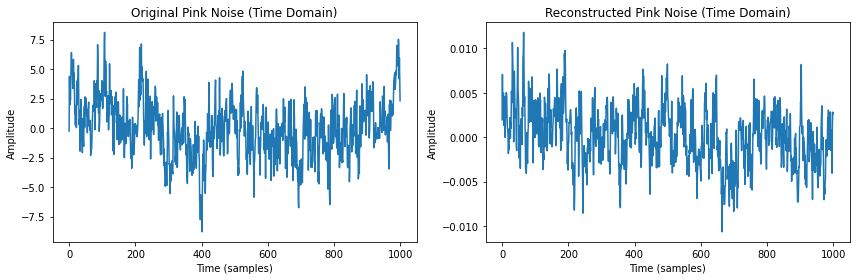

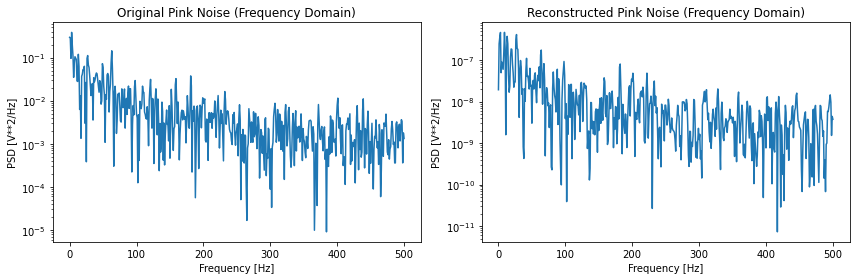

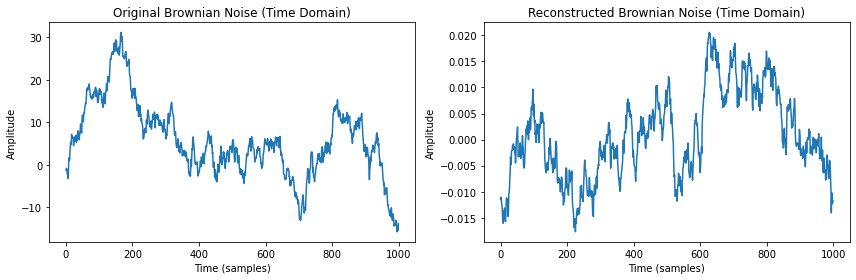

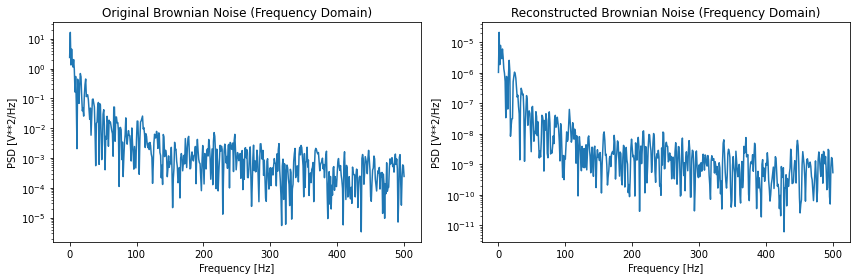

In [50]:
noise_psd_gen.plot_time_series_comparison(pink_noise, pink_reconstructed, "Pink Noise")
noise_psd_gen.plot_psd_comparison(pink_noise, pink_reconstructed, noise_psd_gen.fs, "Pink Noise")

noise_psd_gen.plot_time_series_comparison(brownian_noise, brownian_reconstructed, "Brownian Noise")
noise_psd_gen.plot_psd_comparison(brownian_noise, brownian_reconstructed, noise_psd_gen.fs, "Brownian Noise")